# Linear non-Gaussian acyclic model (LiNGAM)

## Introduction

The LiNGAM model for $p$ observed variables $x_1, x_2, \ldots, x_p$ is given by

\begin{equation}
    x_i = \sum_{j \in \operatorname{pa}(x_i)}b_{ij}x_j + e_i \quad (i=1, \ldots, p)
\end{equation}

that explains how each observed variable $x_i$ is a linear sum of their parent variables $\operatorname{pa}(x_i)$ plus some noise $e_i$. If the coefficient $b_{ij}$ is zero, then there is no direct causal effect from $x_j$ to $x_i$. The error variables $e_i$ are **independent** and follow continuous **non-Gaussian** distributions. The independence means there are **no unobserved or hidden common causes**.

See this reference for more information {cite}`Hawking1988`.

## Estimation methods

There are two main approaches to estimate a LiNGAM model: independent component analysis (**ICA**), and **direct** estimation through a series of regressions and independence tests.

### ICA

ICA is a computational method, developed in the field of signal processing, to separate a multivariate signal into additive subcomponents assuming that these subcomponents are non-Gaussian signals and statistically independent from each other. Consider a simple ICA model given by

\begin{align}
    x_1 &= a_{11}s_1 + a_{12}s_2 \\
    x_2 &= a_{21}s_1 + a_{22}s_2
\end{align}

where $x_1$ and $x_2$ are the observed variables, and $s_1$ and $s_2$ are continuous hidden variables. Assuming that $s_1$ and $s_2$ are **independent** and **non-Gaussian**, ICA attempts to recover them from the observed matrix $\mathbf{X}$. In matrix form, we can write it as

\begin{equation}
    \mathbf{x} = \mathbf{A}\mathbf{s}
\end{equation}

In our example, it would mean

\begin{equation}
    \left[\begin{array}{c} 
    x_1 \\ x_2
    \end{array}\right]
    =\left[\begin{array}{cc}
    a_{11} & a_{12} \\
    a_{21} & a_{22}
    \end{array}\right]
    \left[\begin{array}{c}
    s_1 \\
    s_2
    \end{array}\right]
\end{equation}

The $p \times q$ mixing matrix $\mathbf{A}$ represents how the unobserved components $\mathbf{s}$ are mixed to generate the observed variables $\mathbf{x}$. Any two columns of $\mathbf{A}$ are assumed to be linearly independent. The mixing matrix $\mathbf{A}$ is identifiable, except for the **ordering** and **scaling** of its columns. 

In [1]:
from sklearn.decomposition import FastICA
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We start by generating the original signals $s_1$ and $s_2$

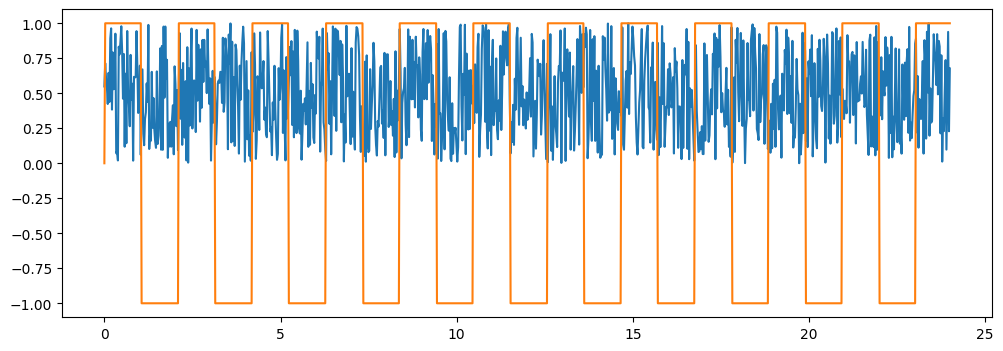

In [2]:
np.random.seed(0)
sample_size = 1000
time = np.linspace(0, 24, sample_size)
s1 = np.random.uniform(low=0, high=1, size=sample_size)
s2 = np.sign(np.sin(3 * time))  # Signal 2: square signal
S = np.c_[s1, s2]
plt.figure(figsize=(12, 4))
plt.plot(time, S)

We now mix the signals, to generate the observed matrix $\mathbf{X}$ 

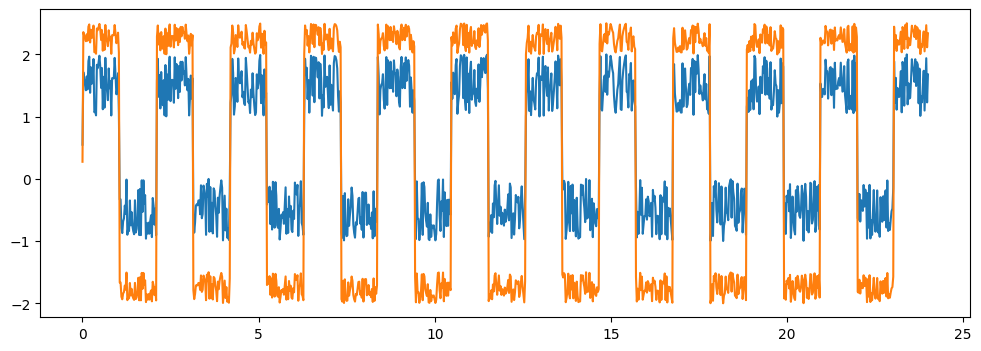

In [3]:
# Mix data
A = np.array([[1, 1], [0.5, 2]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations
plt.figure(figsize=(12, 4))
plt.plot(time, X)

Now, we can use ICA to recover the original signals (except for the **ordering** and **scaling**)

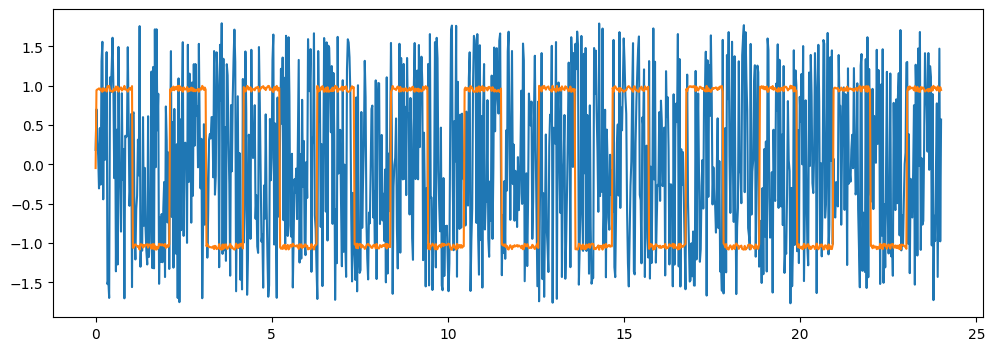

In [4]:
ica = FastICA(n_components=2)
recovered_signals = ica.fit_transform(X)  # Reconstruct signals
plt.figure(figsize=(12, 4))
plt.plot(time, recovered_signals)

### ICA-based LiNGAM

In matrix notation, the model is given by

\begin{equation}
    \mathbf{x} = \mathbf{B}\mathbf{x} + \mathbf{e}
\end{equation}

where $\mathbf{x}$ and $\mathbf{e}$ are $p$-dimensional vectors, and $\mathbf{B}$ is a $p\times p$ matrix that contains the $b_{ij}$ coefficients, with $i, j=1, \ldots, p$. We can solve the equation $\mathbf{x} = \mathbf{B}\mathbf{x} + \mathbf{e}$ for the vector of observed variables $\mathbf{x}$ as in

\begin{equation}
    (\mathbf{I}- \mathbf{B})\mathbf{x} = \mathbf{e}
\end{equation}

Then, if we left-multiply both sides by the inverse of $\mathbf{I}- \mathbf{B}$, we get

\begin{align}
    (\mathbf{I}- \mathbf{B})^{-1}(\mathbf{I}- \mathbf{B})\mathbf{x} &= (\mathbf{I}- \mathbf{B})^{-1}\mathbf{e} \\
    \mathbf{x} &= (\mathbf{I}- \mathbf{B})^{-1}\mathbf{e} \\
    \mathbf{x} &= \mathbf{A}\mathbf{e} \label{eq:lingam-ica}
\end{align}

Now, since we assumed the errors are independent and non-Gaussian, we have that this equation corresponds to the ICA model, and the matrix $\mathbf{A} = (\mathbf{I}- \mathbf{B})^{-1}$ corresponds to the mixing matrix in ICA. This gives the hint of why we can use ICA to estimate the LiNGAM model. The cool part is that, in this case, using the **acyclicity assumption**, we can also find the coefficients in terms of the right **ordering** and **scaling**.

Let's start by generating data from a known causal structure.

In [5]:
import pandas as pd
import lingam
from lingam.utils import print_causal_directions, print_dagc, make_dot
from lingam.utils import make_dot

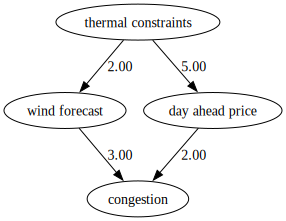

In [6]:
# Linear structural equations with non-Gaussian noise
sample_size = 1000
x3 = np.random.uniform(low=0, high=1, size=sample_size)
x0 = 2.0*x3 + np.random.uniform(low=0, high=1, size=sample_size)
x2 = 5.0*x3 + np.random.beta(a=2, b=8, size=sample_size)
x1 = 3.0*x0 + 2.0*x2 + np.random.exponential(scale=1, size=sample_size)
X = pd.DataFrame(np.array([x0, x1, x2, x3]).T, columns=['x0', 'x1', 'x2', 'x3'])

# Matrix of coefficients
m = np.array([[0.0, 0.0, 0.0, 2.0],
              [3.0, 0.0, 2.0, 0.0],
              [0.0, 0.0, 0.0, 5.0],
              [0.0, 0.0, 0.0, 0.0]])

# Saving graph
make_dot(m, labels=["wind forecast", "congestion", "day ahead price", "thermal constraints"])
        #, path=(3, 1), path_color="red")

We can now apply ICA to retrieve the independent components

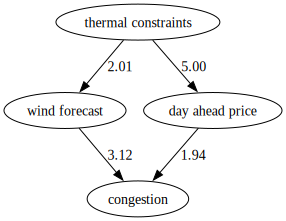

In [7]:
# ICA-based LiNGAM
ica_model = lingam.ICALiNGAM()
ica_model.fit(X)
ica_model.causal_order_
ica_model.adjacency_matrix_
make_dot(ica_model.adjacency_matrix_, labels=["wind forecast", "congestion", "day ahead price", "thermal constraints"])

## Direct estimation
Instead of using ICA, DirectLiNGAM is an iterative procedure that employs a series of regressions and independence tests to directly identify the causal order among the observed variables. It leverages the non-Gaussianity of the data and the assumption of linear causality to systematically test for independence between variables and their residuals from regressions. The key intuition is that, with non-Gaussian errors, the **residuals in the anti-causal direction** will not be independent of the predictor.

### Residual analysis: non-Gaussian vs. Gaussian error terms

In [8]:
import statsmodels.api as sm

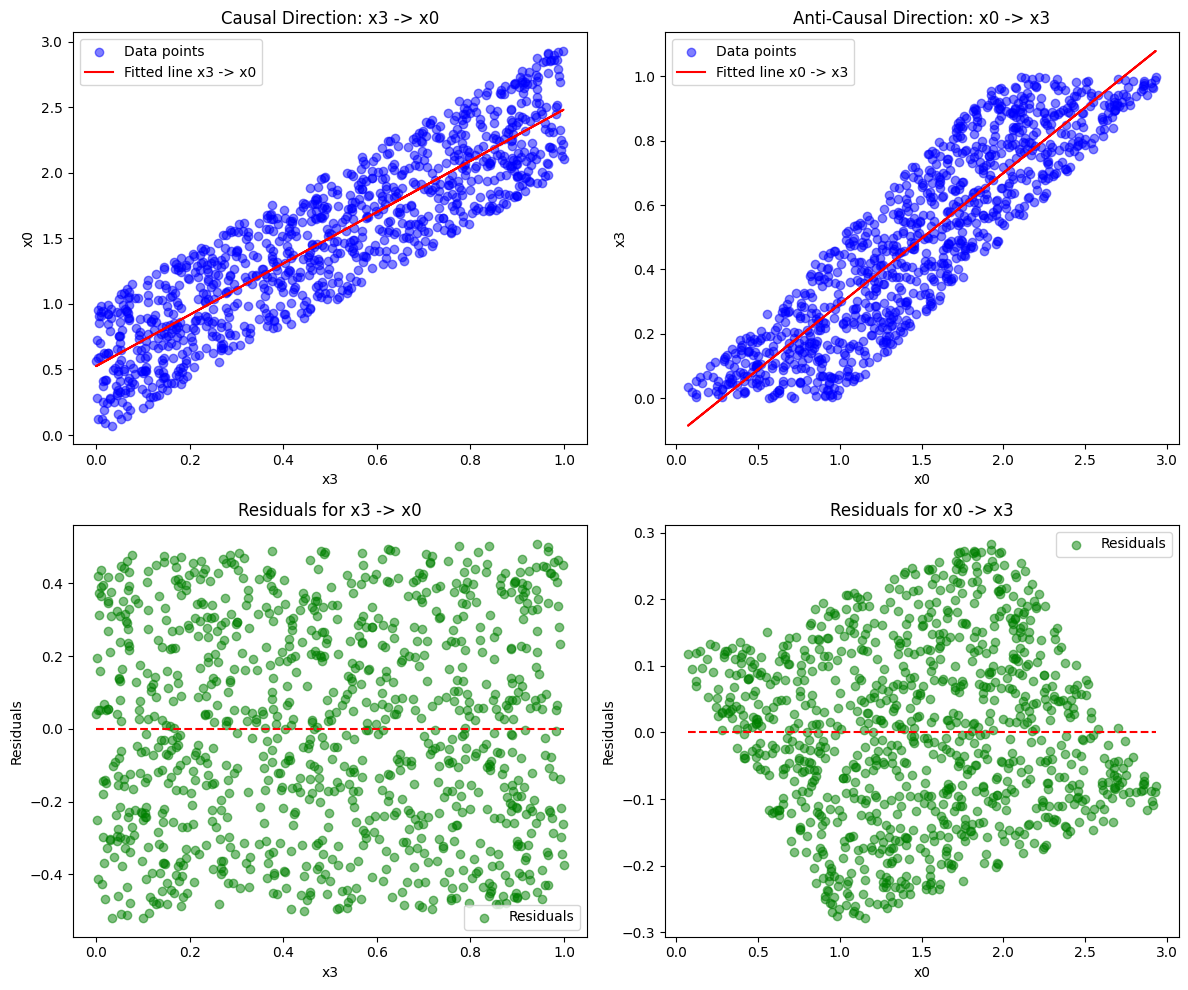

In [9]:
# Updated synthetic data generation based on the given equations
sample_size = 1000
x3 = np.random.uniform(low=0, high=1, size=sample_size)  # Predictor variable
x0 = 2.0 * x3 + np.random.uniform(low=0, high=1, size=sample_size)  # Response variable with non-Gaussian noise (uniform)

# Linear regression in the correct causal direction (x3 -> x0)
X3 = sm.add_constant(x3)
model3 = sm.OLS(x0, X3)
results3 = model3.fit()
y_pred3 = results3.predict(X3)
residuals3 = x0 - y_pred3

# Linear regression in the incorrect anti-causal direction (x0 -> x3)
X0 = sm.add_constant(x0)
model0 = sm.OLS(x3, X0)
results0 = model0.fit()
y_pred0 = results0.predict(X0)
residuals0 = x3 - y_pred0

# Plotting
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Plot x3 vs x0 with regression line
ax[0, 0].scatter(x3, x0, color='blue', alpha=0.5, label='Data points')
ax[0, 0].plot(x3, y_pred3, 'r-', label='Fitted line x3 -> x0')
ax[0, 0].set_xlabel('x3')
ax[0, 0].set_ylabel('x0')
ax[0, 0].set_title('Causal Direction: x3 -> x0')
ax[0, 0].legend()

# Plot residuals for the correct causal direction
ax[1, 0].scatter(x3, residuals3, color='green', alpha=0.5, label='Residuals')
ax[1, 0].hlines(0, xmin=min(x3), xmax=max(x3), colors='red', linestyles='--')
ax[1, 0].set_xlabel('x3')
ax[1, 0].set_ylabel('Residuals')
ax[1, 0].set_title('Residuals for x3 -> x0')
ax[1, 0].legend()

# Plot x0 vs x3 with regression line
ax[0, 1].scatter(x0, x3, color='blue', alpha=0.5, label='Data points')
ax[0, 1].plot(x0, y_pred0, 'r-', label='Fitted line x0 -> x3')
ax[0, 1].set_xlabel('x0')
ax[0, 1].set_ylabel('x3')
ax[0, 1].set_title('Anti-Causal Direction: x0 -> x3')
ax[0, 1].legend()

# Plot residuals for the incorrect causal direction
ax[1, 1].scatter(x0, residuals0, color='green', alpha=0.5, label='Residuals')
ax[1, 1].hlines(0, xmin=min(x0), xmax=max(x0), colors='red', linestyles='--')
ax[1, 1].set_xlabel('x0')
ax[1, 1].set_ylabel('Residuals')
ax[1, 1].set_title('Residuals for x0 -> x3')
ax[1, 1].legend()

plt.tight_layout()
plt.show()

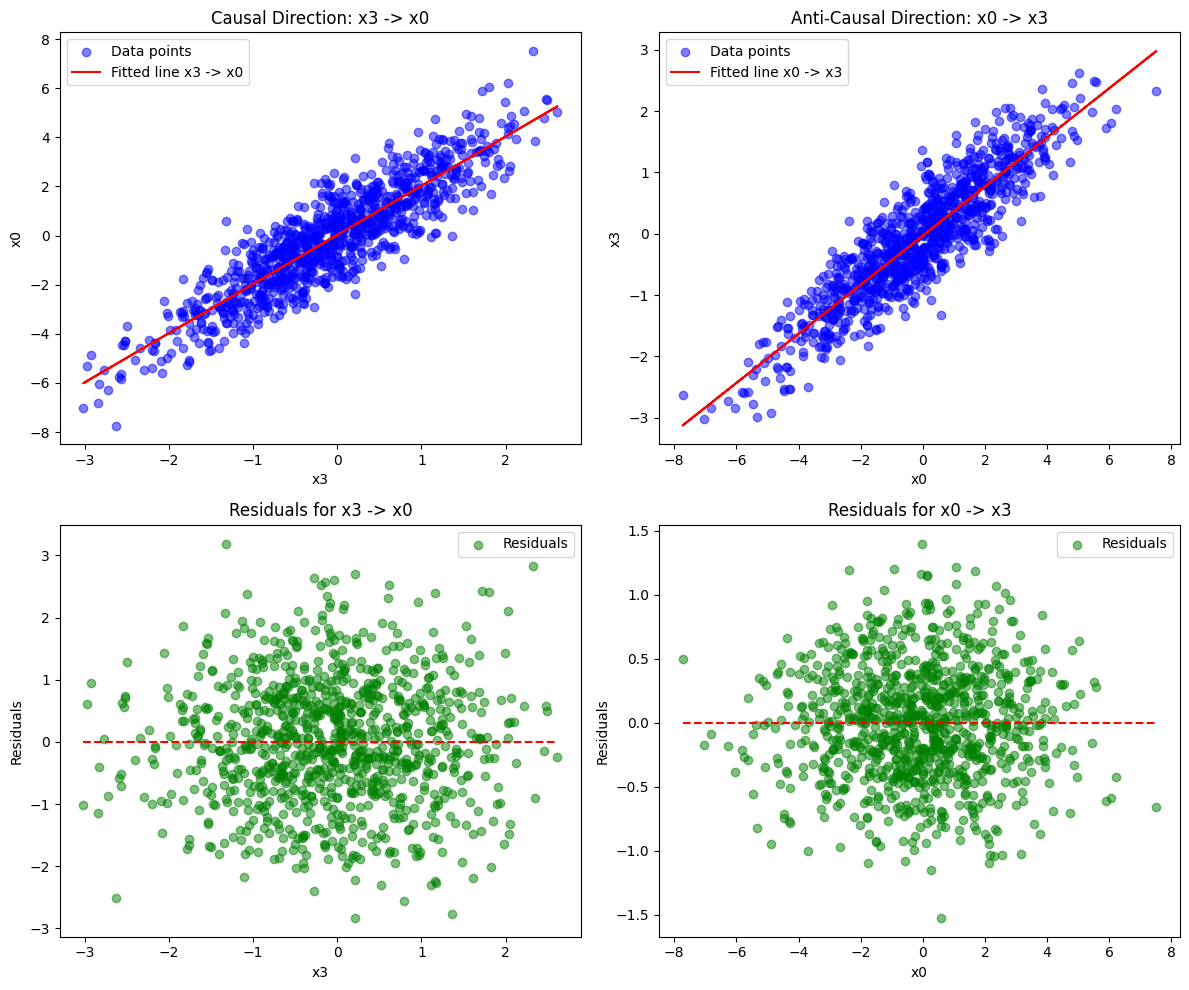

In [10]:
# Updated synthetic data generation based on the given equations
sample_size = 1000
x3 = np.random.normal(size=sample_size)  # Predictor variable
x0 = 2.0 * x3 + np.random.normal(size=sample_size)  # Response variable with non-Gaussian noise (uniform)

# Linear regression in the correct causal direction (x3 -> x0)
X3 = sm.add_constant(x3)
model3 = sm.OLS(x0, X3)
results3 = model3.fit()
y_pred3 = results3.predict(X3)
residuals3 = x0 - y_pred3

# Linear regression in the incorrect anti-causal direction (x0 -> x3)
X0 = sm.add_constant(x0)
model0 = sm.OLS(x3, X0)
results0 = model0.fit()
y_pred0 = results0.predict(X0)
residuals0 = x3 - y_pred0

# Plotting
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Plot x3 vs x0 with regression line
ax[0, 0].scatter(x3, x0, color='blue', alpha=0.5, label='Data points')
ax[0, 0].plot(x3, y_pred3, 'r-', label='Fitted line x3 -> x0')
ax[0, 0].set_xlabel('x3')
ax[0, 0].set_ylabel('x0')
ax[0, 0].set_title('Causal Direction: x3 -> x0')
ax[0, 0].legend()

# Plot residuals for the correct causal direction
ax[1, 0].scatter(x3, residuals3, color='green', alpha=0.5, label='Residuals')
ax[1, 0].hlines(0, xmin=min(x3), xmax=max(x3), colors='red', linestyles='--')
ax[1, 0].set_xlabel('x3')
ax[1, 0].set_ylabel('Residuals')
ax[1, 0].set_title('Residuals for x3 -> x0')
ax[1, 0].legend()

# Plot x0 vs x3 with regression line
ax[0, 1].scatter(x0, x3, color='blue', alpha=0.5, label='Data points')
ax[0, 1].plot(x0, y_pred0, 'r-', label='Fitted line x0 -> x3')
ax[0, 1].set_xlabel('x0')
ax[0, 1].set_ylabel('x3')
ax[0, 1].set_title('Anti-Causal Direction: x0 -> x3')
ax[0, 1].legend()

# Plot residuals for the incorrect causal direction
ax[1, 1].scatter(x0, residuals0, color='green', alpha=0.5, label='Residuals')
ax[1, 1].hlines(0, xmin=min(x0), xmax=max(x0), colors='red', linestyles='--')
ax[1, 1].set_xlabel('x0')
ax[1, 1].set_ylabel('Residuals')
ax[1, 1].set_title('Residuals for x0 -> x3')
ax[1, 1].legend()

plt.tight_layout()
plt.show()

### DirectLiNGAM

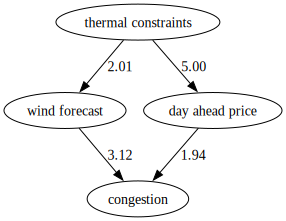

In [11]:
direct_model = lingam.DirectLiNGAM()
direct_model.fit(X)
direct_model.causal_order_
direct_model.adjacency_matrix_
make_dot(direct_model.adjacency_matrix_, labels=["wind forecast", "congestion", "day ahead price", "thermal constraints"])